In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ursse.phase_space_trajectory as pst
import ursse_cpp.sync_motion_sim as sm
from config_ursse import get_from_config
iota_period_sec = get_from_config("IOTA_revolution_period")
df0 = pst.get_revolution_delay_df_one_gate('shift_02_28_2020', '1el_002.ptu')
T0 = pst.get_initial_sync_period_estimate(df0)

In [2]:
from ursse.path_assistant import PathAssistant
shift = PathAssistant('shift_02_28_2020')

In [46]:
gamma = get_from_config("gamma")
alpha = get_from_config("ring_alpha")
V = 380
f = 1/get_from_config("IOTA_revolution_period")
h = get_from_config("RF_q")
JE = get_from_config("damping_partition_JE")
rho=70
hbar_c = 0.1973269804e-4
gamma_to_nav = 0.0661969
Ec = 3 / 2 * hbar_c * pow(gamma, 3) / rho
nav = gamma_to_nav*gamma

# Energy per turn distribution

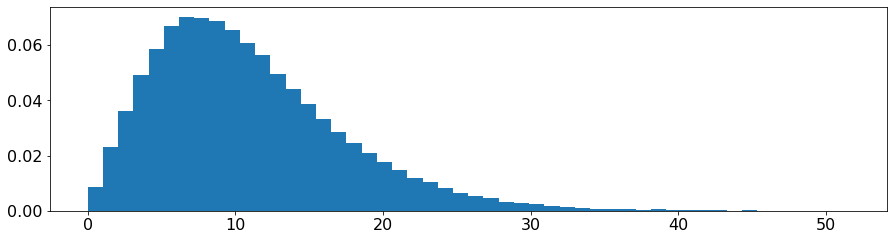

In [4]:
nrev = 100000
nphs = np.random.poisson(lam=nav, size=nrev)
ens = np.zeros(nrev)
for i,nph in enumerate(nphs):
    ens[i] = sum([sm.InvSynchFractInt(r) for r in np.random.rand(nph)])*Ec
plt.hist(ens, bins=50, density=True)
plt.show()

In [5]:
Eav = np.mean(ens)
Eav

10.91439411507965

In [6]:
Estd = np.std(ens)
Estd

6.408277897055623

In [7]:
M = 1/(Estd/Eav)**2
M

2.900792008520905

In [8]:
k = M
theta = Eav/M
k, theta

(2.900792008520905, 3.762556599376744)

# Comparison of Gamma distribution with the simulated one

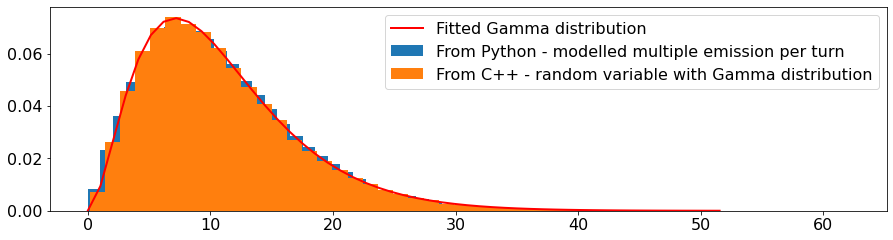

In [9]:
shape, scale = k, theta  # mean=4, std=2*sqrt(2)
nrolls = 100000
s = np.random.gamma(shape, scale, nrolls)
import scipy.special as sps  
count, bins, ignored = plt.hist(ens, bins=50, density=True,
        label='From Python - modelled multiple emission per turn')
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r', label='Fitted Gamma distribution')  
plt.hist(sm.RandomEnergyGammaDistribution(k, theta, nrolls, 42),
         bins=50, density=True,
         label='From C++ - random variable with Gamma distribution')
plt.legend()
plt.show()

# Distribution for a single emitted photon

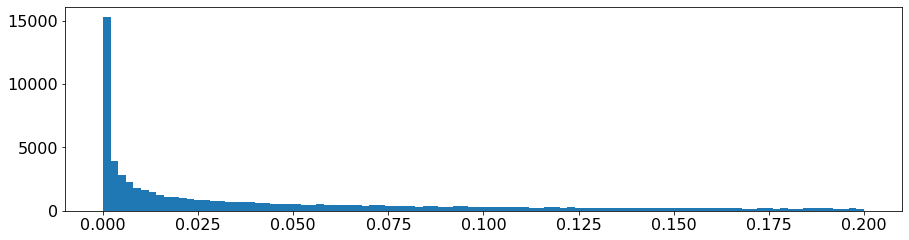

In [10]:
rands = np.random.rand(100000)
en = np.zeros(shape=rands.shape)
Et = 88.9e-7*pow((gamma*0.511),4)/rho
Scale = 15*np.sqrt(3)/8*Et
for i,r in enumerate(rands):
    en[i] = sm.InvSynchFractInt(r)
plt.hist(en, bins=100, range=(0,0.2))
plt.show()

In [11]:
np.mean(en)*Scale

10.889322589435617

In [12]:
Scale*np.std(en)

19.537957617400544

In [13]:
spad_tts = 0.35

In [14]:
phase_df = pst.get_phase_df_from_revoluton_delay_df(df0, T0)
sz_df = pst.get_sz_df(df0, spad_tts_ns=spad_tts)
polar_df = pst.get_polar_df(phase_df, sz_df)

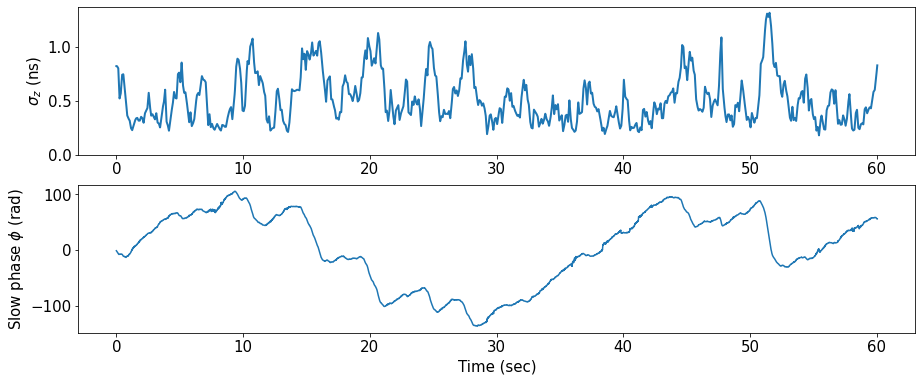

In [15]:
pst.plot_polar_df_cartesian(polar_df)

In [16]:
%%time
sim_df = sm.get_simulated_revolution_delay_data(
    gamma, alpha, V, f, h, JE, k, theta,
    df0['revolution'],
    tau0=0, delta0=0, rand_seed_int=3)

CPU times: user 1min 28s, sys: 120 ms, total: 1min 28s
Wall time: 1min 28s


In [17]:
import os

In [18]:
# sim_df.to_csv(os.path.join(shift.shift_results_dir,"sim_df.csv"))

In [19]:
# sim_df = pd.read_csv(os.path.join(shift.shift_results_dir,"sim_df.csv"))

In [20]:
sim_df['delay'] = sim_df['delay']-sim_df['delay'].mean() 

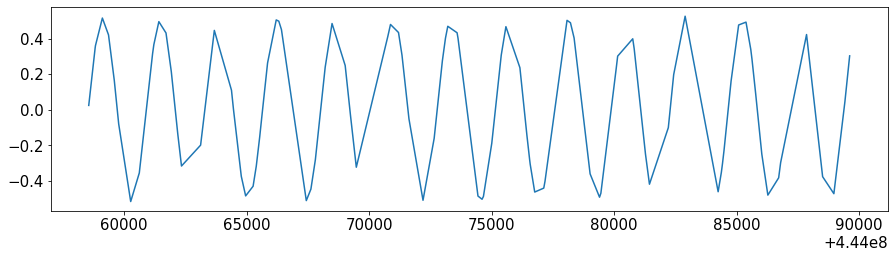

In [21]:
n1 = 1460000
dn = 100
plt.plot(sim_df.loc[n1:n1+dn,'revolution'], sim_df.loc[n1:n1+dn,'delay'])

In [22]:
sim_sz_df = pst.get_sz_df(sim_df, spad_tts_ns=0)

Text(0.5, 0, 'Time (sec)')

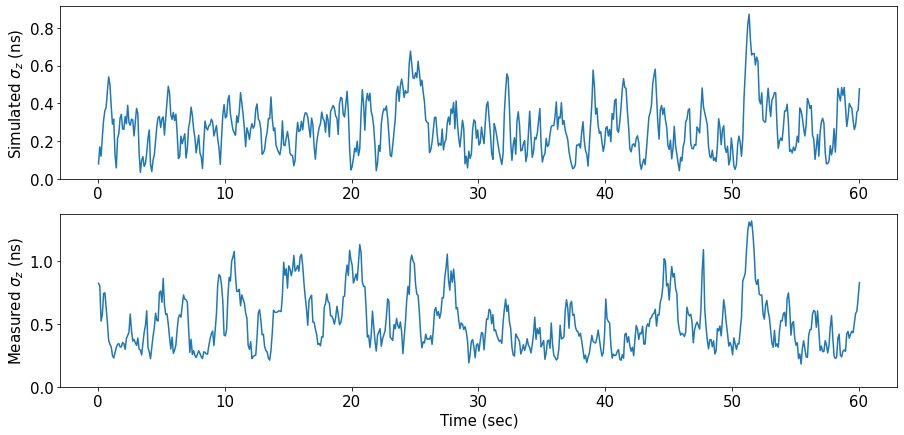

In [23]:
fig, ax = plt.subplots(2, figsize=(15,7))
ax[0].plot(sim_sz_df['time_sec'], sim_sz_df['sz_ns'])
ax[0].set_ylim(0,ax[0].get_ylim()[1])
ax[0].set_ylabel("Simulated $\sigma_z$ (ns)")
ax[1].plot(sz_df['time_sec'], sz_df['sz_ns'])
ax[1].set_ylim(0,ax[1].get_ylim()[1])
ax[1].set_ylabel("Measured $\sigma_z$ (ns)")
ax[1].set_xlabel("Time (sec)")

In [24]:
sim_df.delay.std()

0.30569008142526277

In [25]:
df0.delay.std()

0.6579678305110525

In [30]:
sim_sz_df['sz_ns'].mean()

0.27610177423035415

In [31]:
sz_df['sz_ns'].mean()

0.5124594181148768

In [32]:
pd.set_option('display.max_rows', None)

In [33]:
sim_df[sim_df['time_sec']==0.05]['delay'].std()

0.08103931043448685

In [35]:
sim_sz_df['sz_ns'].std()

0.1324992399387218

In [36]:
5.855*8.725e-5

0.0005108487500000001

# Textbook results for  rms of $\tau$

In [47]:
c = 2.9979e10
v0 = V/E0
eta = alpha - 1/gamma**2
w = 2*np.pi*h*eta

In [48]:
ts = 0.836
JE = 2*E0*iota_period_sec/ts/Et
delta_rms = 0.62e-6*gamma/np.sqrt(JE*rho/100)
print("delta rms = ", delta_rms)
tau_rms = 1e9*delta_rms/((f*h)*2*np.pi*np.sqrt(V/(2*np.pi*E0*h*np.abs(eta))))
print("tau_rms = ", tau_rms, "ns")

delta rms =  8.349010114315826e-05
tau_rms =  0.29765621983875945 ns


In [49]:
JE

2.803674761537075

In [50]:
tau_rms*1e-9*c

8.92343581454617